#Import

In [ ]:
import random
import string
import csv
from nltk.corpus import words
import nltk
import time
import matplotlib.pyplot as plt
import numpy as np
import os
import heapq

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Generate data


In [ ]:
# Function to introduce error in a word
def introduce_errors(word, max_errors=2):
    error_types = ['substitute', 'insert', 'delete']
    num_errors = random.randint(1, min(max_errors, len(word)))
    modified_word = list(word)

    for _ in range(num_errors):
        error_type = random.choice(error_types)
        if not modified_word:
            error_type = 'insert'

        if error_type == 'substitute' and modified_word:
            pos = random.randint(0, len(modified_word)-1)
            modified_word[pos] = random.choice(string.ascii_lowercase + 'áàảãạâấầẩẫậăắằẳẵặéèẻẽẹêếềểễệíìỉĩịóòỏõọôốồổỗộơớờởỡợúùủũụưứừửữựýỳỷỹỵđ ')
        elif error_type == 'insert':
            pos = random.randint(0, len(modified_word))
            modified_word.insert(pos, random.choice(string.ascii_lowercase + 'áàảãạâấầẩẫậăắằẳẵặéèẻẽẹêếềểễệíìỉĩịóòỏõọôốồổỗộơớờởỡợúùủũụưứừửữựýỳỷỹỵđ '))
        elif error_type == 'delete' and modified_word:
            pos = random.randint(0, len(modified_word)-1)
            modified_word.pop(pos)

    return ''.join(modified_word)


def load_vietnamese_words(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        reader = csv.reader(f)
        next(reader)
        return [row[0] for row in reader if row[0].strip()]

def generate_incorrect_vietnamese_words(words, num_samples):
    selected_words = random.sample(words, min(num_samples, len(words)))
    incorrect_words = [introduce_errors(word) for word in selected_words]
    return list(zip(selected_words, incorrect_words))

def save_to_csv(data, filename):
    with open(filename, 'w', newline='', encoding='utf-8') as f:
        writer = csv.writer(f)
        writer.writerow(['correct', 'incorrect'])
        writer.writerows(data)

<br><br>

In [ ]:
file_path = '/content/drive/MyDrive/Dataset/vietnamese_words.csv'
output_file = 'vietnamese_test_incorrect_words.csv'
num_samples = 100000

if os.path.exists(output_file):
    print(f"{output_file} already exists, skipping generation")
else:
    vietnamese_words = load_vietnamese_words(file_path)
    data = generate_incorrect_vietnamese_words(vietnamese_words, num_samples)
    save_to_csv(data, output_file)
    print(f"Generated {output_file} with {len(data)} pairs")

Generated vietnamese_test_incorrect_words.csv with 73160 pairs


- Gen 1 bộ data vietnamese_words.csv gồm 73160 từ sai lệch so với từ điển

In [ ]:
with open(output_file, 'r', encoding='utf-8') as f:
    reader = csv.reader(f)
    next(reader)
    for i, row in enumerate(reader):
        if i >= 5:
            break
        print(f"Correct: {row[0]}, Incorrect: {row[1]}")

Correct: xà cừ, Incorrect: xà ệừ
Correct: tranh Tết, Incorrect: tanh Tết
Correct: đẩy tạ, Incorrect: đãy ạ
Correct: quán quân, Incorrect: quáb quân
Correct: chia lô, Incorrect: chalô


#LD

In [ ]:
def levenshtein_distance(s1, s2):
    if len(s1) < len(s2):
        s1, s2 = s2, s1

    if len(s2) == 0:
        return len(s1)

    previous_row = range(len(s2) + 1)
    for i, c1 in enumerate(s1):
        current_row = [i + 1]
        for j, c2 in enumerate(s2):
            insertions = previous_row[j + 1] + 1
            deletions = current_row[j] + 1
            substitutions = previous_row[j] + (c1 != c2)
            current_row.append(min(insertions, deletions, substitutions))
        previous_row = current_row

    return previous_row[-1]

def process_vietnamese_levenshtein(input_file, output_file):
    if os.path.exists(output_file):
        print(f"{output_file} already exists, skipping generation")
        return
    results = []
    with open(input_file, 'r', encoding='utf-8') as f:
        reader = csv.reader(f)
        next(reader)
        for row in reader:
            correct, incorrect = row
            distance = levenshtein_distance(correct, incorrect)
            results.append([correct, incorrect, distance])

    with open(output_file, 'w', newline='', encoding='utf-8') as f:
        writer = csv.writer(f)
        writer.writerow(['correct', 'incorrect', 'levenshtein_distance'])
        writer.writerows(results)
    print(f"Generated {output_file}")


process_vietnamese_levenshtein('vietnamese_test_incorrect_words.csv', 'vietnamese_levenshtein_distances.csv')


print("Sample Levenshtein distances (first 5):")
with open('vietnamese_levenshtein_distances.csv', 'r', encoding='utf-8') as f:
    reader = csv.reader(f)
    next(reader)
    for i, row in enumerate(reader):
        if i >= 5:
            break
        print(f"Correct: {row[0]}, Incorrect: {row[1]}, Distance: {row[2]}")

Generated vietnamese_levenshtein_distances.csv
Sample Levenshtein distances (first 5):
Correct: xà cừ, Incorrect: xà ệừ, Distance: 1
Correct: tranh Tết, Incorrect: tanh Tết, Distance: 1
Correct: đẩy tạ, Incorrect: đãy ạ, Distance: 2
Correct: quán quân, Incorrect: quáb quân, Distance: 1
Correct: chia lô, Incorrect: chalô, Distance: 2


<br><br>

#MLD

In [ ]:
CHAR_GROUPS = [
    {'O', 'D', 'Q'},
    {'o', 'd', 'q'},
    {'I', 'J', 'L', 'T'},
    {'U', 'V', 'Ư'},
    {'u', 'v', 'ư'},
    {'F', 'P'},
    {'C', 'G'},
    {'đ', 'd'},
    {'ê', 'e', 'é', 'è', 'ẹ'},
    {'ô', 'o', 'ó', 'ò', 'ọ'},
    {'ư', 'u', 'ú', 'ù', 'ụ'},
    {'á', 'a', 'à', 'ả', 'ã', 'ạ'}
]
CHAR_TO_GROUP = {}
for idx, group in enumerate(CHAR_GROUPS):
    for char in group:
        CHAR_TO_GROUP[char] = idx

def get_substitution_cost(c1, c2):
    if c1 == c2:
        return 0
    group1 = CHAR_TO_GROUP.get(c1, -1)
    group2 = CHAR_TO_GROUP.get(c2, -1)
    return 0.4 if group1 != -1 and group1 == group2 else 1

def modified_levenshtein_distance(s1, s2, threshold=float('inf')):
    if len(s1) < len(s2):
        s1, s2 = s2, s1

    if len(s2) == 0:
        return len(s1)

    dp = [[0.0] * (len(s2) + 1) for _ in range(len(s1) + 1)]
    for i in range(len(s1) + 1):
        dp[i][0] = i
    for j in range(len(s2) + 1):
        dp[0][j] = j

    for i in range(1, len(s1) + 1):
        for j in range(1, len(s2) + 1):
            cost = get_substitution_cost(s1[i-1], s2[j-1])
            dp[i][j] = min(
                dp[i-1][j] + 1,
                dp[i][j-1] + 1,
                dp[i-1][j-1] + cost
            )
            if dp[i][j] > threshold:
                return float('inf')

    return dp[len(s1)][len(s2)]

def print_mld_dp_table(s1, s2):
    m, n = len(s2), len(s1)
    dp = [[0.0] * (n + 1) for _ in range(m + 1)]

    for j in range(n + 1):
        dp[0][j] = j
    for i in range(m + 1):
        dp[i][0] = i

    for i in range(1, m + 1):
        for j in range(1, n + 1):
            cost = get_substitution_cost(s2[i-1], s1[j-1])
            dp[i][j] = min(
                dp[i-1][j] + 1,
                dp[i][j-1] + 1,
                dp[i-1][j-1] + cost
            )


    print(f"\nMLD DP Table for '{s1}' -> '{s2}':")
    s1_display = [char if char != ' ' else '␣' for char in s1]
    s2_display = [char if char != ' ' else '␣' for char in s2]
    print("   ", "  ".join([' '] + s1_display))
    for i in range(m + 1):
        row = [s2_display[i-1] if i > 0 else ' ']
        row.extend([f"{dp[i][j]:.1f}" for j in range(n + 1)])
        print("  ".join(row))

def process_vietnamese_mld(input_file, output_file):
    if os.path.exists(output_file):
        print(f"{output_file} already exists, skipping generation")
        return
    results = []
    with open(input_file, 'r', encoding='utf-8') as f:
        reader = csv.reader(f)
        next(reader)
        for row in reader:
            correct, incorrect = row
            distance = modified_levenshtein_distance(correct, incorrect)
            results.append([correct, incorrect, distance])

    with open(output_file, 'w', newline='', encoding='utf-8') as f:
        writer = csv.writer(f)
        writer.writerow(['correct', 'incorrect', 'mld_distance'])
        writer.writerows(results)
    print(f"Generated {output_file}")


process_vietnamese_mld('vietnamese_test_incorrect_words.csv', 'vietnamese_mld_distances.csv')


print("Sample MLD distances (first 5):")
with open('vietnamese_mld_distances.csv', 'r', encoding='utf-8') as f:
    reader = csv.reader(f)
    next(reader)
    for i, row in enumerate(reader):
        if i >= 5:
            break
        print(f"Correct: {row[0]}, Incorrect: {row[1]}, Distance: {row[2]}")


print_mld_dp_table("học sinh", "học sịnh")

Generated vietnamese_mld_distances.csv
Sample MLD distances (first 5):
Correct: xà cừ, Incorrect: xà ệừ, Distance: 1
Correct: tranh Tết, Incorrect: tanh Tết, Distance: 1
Correct: đẩy tạ, Incorrect: đãy ạ, Distance: 2
Correct: quán quân, Incorrect: quáb quân, Distance: 1
Correct: chia lô, Incorrect: chalô, Distance: 2

MLD DP Table for 'học sinh' -> 'học sịnh':
       h  ọ  c  ␣  s  i  n  h
   0.0  1.0  2.0  3.0  4.0  5.0  6.0  7.0  8.0
h  1.0  0.0  1.0  2.0  3.0  4.0  5.0  6.0  7.0
ọ  2.0  1.0  0.0  1.0  2.0  3.0  4.0  5.0  6.0
c  3.0  2.0  1.0  0.0  1.0  2.0  3.0  4.0  5.0
␣  4.0  3.0  2.0  1.0  0.0  1.0  2.0  3.0  4.0
s  5.0  4.0  3.0  2.0  1.0  0.0  1.0  2.0  3.0
ị  6.0  5.0  4.0  3.0  2.0  1.0  1.0  2.0  3.0
n  7.0  6.0  5.0  4.0  3.0  2.0  2.0  1.0  2.0
h  8.0  7.0  6.0  5.0  4.0  3.0  3.0  2.0  1.0


<br><br>

#Accuracy

In [ ]:
def calculate_accuracy(distance_file, threshold=1):
    correct_count = 0
    total_count = 0

    with open(distance_file, 'r', encoding='utf-8') as f:
        reader = csv.reader(f)
        next(reader)
        for row in reader:
            correct, incorrect, distance = row
            distance = float(distance)
            if distance <= threshold:
                correct_count += 1
            total_count += 1

    accuracy = correct_count / total_count if total_count > 0 else 0
    return accuracy

levenshtein_accuracy = calculate_accuracy('vietnamese_levenshtein_distances.csv')
mld_accuracy = calculate_accuracy('vietnamese_mld_distances.csv')

print(f"Accuracy based on Levenshtein Distance (threshold={1}): {levenshtein_accuracy:.2%}")
print(f"Accuracy based on Modified Levenshtein Distance (threshold={1}): {mld_accuracy:.2%}")

custom_threshold_accuracy = calculate_accuracy('vietnamese_mld_distances.csv', threshold=2)
print(f"Accuracy with custom threshold=2 (MLD): {custom_threshold_accuracy:.2%}")

Accuracy based on Levenshtein Distance (threshold=1): 55.22%
Accuracy based on Modified Levenshtein Distance (threshold=1): 55.22%
Accuracy with custom threshold=2 (MLD): 100.00%


- Threshold = 1:
  - Cả LD và MLD có độ chính xác 55.22%, nghĩa là 55.22% các cặp (correct, incorrect) có dist ≤ 1.
  - Sự giống nhau giữa LD và MLD (55.22%) cho thấy MLD chưa tận dụng được ưu thế giảm cost, có thể CHARS_GROUP chưa được tối ưu

- Threshold = 2:
  - Độ chính xác đạt 100%, nghĩa là tất cả các cặp trong tập dữ liệu vietnamese_test_incorrect_words.csv  có khoảng cách MLD ≤ 2
  - Cải thiện độ chính xác lên 100%, phù hợp để sửa lỗi chính tả với các lỗi nhỏ (chèn/xóa/thay thế 1-2 ký tự).

<br><br>

#Time complexity

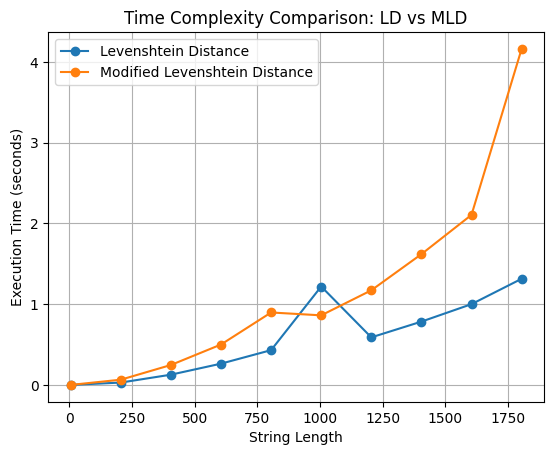

Average LD time: 0.575917 seconds
Average MLD time: 1.163352 seconds
Average Levenshtein Distance: 1.44
Average Modified Levenshtein Distance: 1.44
Difference (LD - MLD): 0.00


In [ ]:
def measure_ld_time(s1, s2):
    start_time = time.time()
    def levenshtein_distance(s1, s2):
        if len(s1) < len(s2):
            s1, s2 = s2, s1
        if len(s2) == 0:
            return len(s1)
        previous_row = range(len(s2) + 1)
        for i, c1 in enumerate(s1):
            current_row = [i + 1]
            for j, c2 in enumerate(s2):
                insertions = previous_row[j + 1] + 1
                deletions = current_row[j] + 1
                substitutions = previous_row[j] + (c1 != c2)
                current_row.append(min(insertions, deletions, substitutions))
            previous_row = current_row
        return previous_row[-1]
    levenshtein_distance(s1, s2)
    return time.time() - start_time

def measure_mld_time(s1, s2):
    start_time = time.time()
    CHAR_GROUPS = [
        {'O', 'D', 'Q'},
        {'o', 'd', 'q'},
        {'I', 'J', 'L', 'T'},
        {'U', 'V', 'Ư'},
        {'u', 'v', 'ư'},
        {'F', 'P'},
        {'C', 'G'},
        {'đ', 'd'},
        {'ê', 'e', 'é', 'è', 'ẹ'},
        {'ô', 'o', 'ó', 'ò', 'ọ'},
        {'ư', 'u', 'ú', 'ù', 'ụ'},
        {'á', 'a', 'à', 'ả', 'ã', 'ạ'}
    ]
    CHAR_TO_GROUP = {}
    for idx, group in enumerate(CHAR_GROUPS):
        for char in group:
            CHAR_TO_GROUP[char] = idx

    def get_substitution_cost(c1, c2):
        if c1 == c2:
            return 0
        group1 = CHAR_TO_GROUP.get(c1, -1)
        group2 = CHAR_TO_GROUP.get(c2, -1)
        return 0.4 if group1 != -1 and group1 == group2 else 1

    def modified_levenshtein_distance(s1, s2, threshold=float('inf')):
        if len(s1) < len(s2):
            s1, s2 = s2, s1
        if len(s2) == 0:
            return len(s1)
        dp = [[0.0] * (len(s2) + 1) for _ in range(len(s1) + 1)]
        for i in range(len(s1) + 1):
            dp[i][0] = i
        for j in range(len(s2) + 1):
            dp[0][j] = j
        for i in range(1, len(s1) + 1):
            for j in range(1, len(s2) + 1):
                cost = get_substitution_cost(s1[i-1], s2[j-1])
                dp[i][j] = min(
                    dp[i-1][j] + 1,
                    dp[i][j-1] + 1,
                    dp[i-1][j-1] + cost
                )
                if dp[i][j] > threshold:
                    return float('inf')
        return dp[len(s1)][len(s2)]

    modified_levenshtein_distance(s1, s2)
    return time.time() - start_time

lengths = range(5, 2000, 200)
ld_times = []
mld_times = []

for length in lengths:
    s1 = ''.join(random.choices(string.ascii_lowercase + 'áàảãạâấầẩẫậăắằẳẵặéèẻẽẹêếềểễệíìỉĩịóòỏõọôốồổỗộơớờởỡợúùủũụưứừửữựýỳỷỹỵđ ', k=length))
    s2 = ''.join(random.choices(string.ascii_lowercase + 'áàảãạâấầẩẫậăắằẳẵặéèẻẽẹêếềểễệíìỉĩịóòỏõọôốồổỗộơớờởỡợúùủũụưứừửữựýỳỷỹỵđ ', k=length))
    ld_times.append(measure_ld_time(s1, s2))
    mld_times.append(measure_mld_time(s1, s2))


plt.plot(lengths, ld_times, label='Levenshtein Distance', marker='o')
plt.plot(lengths, mld_times, label='Modified Levenshtein Distance', marker='o')
plt.xlabel('String Length')
plt.ylabel('Execution Time (seconds)')
plt.title('Time Complexity Comparison: LD vs MLD')
plt.legend()
plt.grid(True)
plt.show()


print(f"Average LD time: {np.mean(ld_times):.6f} seconds")
print(f"Average MLD time: {np.mean(mld_times):.6f} seconds")

def calculate_average_distances(input_file):
    ld_distances = []
    mld_distances = []
    with open(input_file, 'r', encoding='utf-8') as f:
        reader = csv.reader(f)
        next(reader)
        for row in reader:
            correct, incorrect, ld_dist = row
            ld_distances.append(float(ld_dist))

    with open('vietnamese_mld_distances.csv', 'r', encoding='utf-8') as f:
        reader = csv.reader(f)
        next(reader)  #
        for row in reader:
            correct, incorrect, mld_dist = row
            mld_distances.append(float(mld_dist))

    return np.mean(ld_distances), np.mean(mld_distances)

ld_avg, mld_avg = calculate_average_distances('vietnamese_levenshtein_distances.csv')
print(f"Average Levenshtein Distance: {ld_avg:.2f}")
print(f"Average Modified Levenshtein Distance: {mld_avg:.2f}")
print(f"Difference (LD - MLD): {ld_avg - mld_avg:.2f}")

#Spell checking



In [ ]:
def load_dictionary(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        reader = csv.reader(f)
        next(reader)
        return [row[0] for row in reader if row[0].strip()]

def correct_spelling_top_k(input_word, dictionary, k=3):
    distances = []
    for word in dictionary:
        distance = modified_levenshtein_distance(input_word, word)
        heapq.heappush(distances, (distance, word))
    top_k = heapq.nsmallest(k, distances)
    return [(word, distance) for distance, word in top_k]


dictionary_file = '/content/drive/MyDrive/Dataset/vietnamese_words.csv'
dictionary = load_dictionary(dictionary_file)

while True:
    input_word = input("Nhập từ sai (nhập 'q' để thoát): ").strip().lower()
    if input_word == 'q':
        break
    if not input_word:
        print("Vui lòng nhập từ!")
        continue
    k = 3
    suggestions = correct_spelling_top_k(input_word, dictionary, k)
    print(f"Từ sai: {input_word}")
    print(f"Top-{k} gợi ý sửa (dựa trên MLD):")
    for word, distance in suggestions:
        print(f"- {word}: khoảng cách MLD = {distance:.2f}")
    print()

Nhập từ sai (nhập 'q' để thoát): q


#Top-k Suggestions

In [ ]:
def correct_spelling_top_k(input_word, dictionary, k=3):
    distances = []
    for word in dictionary:
        distance = modified_levenshtein_distance(input_word, word)
        heapq.heappush(distances, (distance, word))
    top_k = heapq.nsmallest(k, distances)
    return [(word, distance) for distance, word in top_k]


dictionary_file = '/content/drive/MyDrive/Dataset/vietnamese_words.csv'
dictionary = load_dictionary(dictionary_file)


while True:
    input_word = input("Nhập từ sai (nhập 'q' để thoát): ").strip().lower()
    if input_word == 'q':
        break
    if not input_word:
        print("Vui lòng nhập từ!")
        continue
    k = 3
    suggestions = correct_spelling_top_k(input_word, dictionary, k)
    print(f"Từ sai: {input_word}")
    print(f"Top-{k} gợi ý sửa (dựa trên MLD):")
    for word, distance in suggestions:
        print(f"- {word}: khoảng cách MLD = {distance:.2f}")
    print()

Nhập từ sai (nhập 'q' để thoát): q
